In [2]:
import gym
from gym import spaces
from gym.utils import seeding
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return

In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm
#ray.init()
import glob
import matplotlib.pylab as plt

# Building a stock trading environment

First things first, we need to make sure that we can actually get the price data from somewhere.

I got it from here https://www.kaggle.com/camnugent/sandp500?select=individual_stocks_5yr

It's got 5 years of price data in it.

In [4]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False,_temp_dir="/rds/general/user/asm119/ephemeral")

2020-11-17 21:28:23,929	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '146.179.60.54',
 'raylet_ip_address': '146.179.60.54',
 'redis_address': '146.179.60.54:6379',
 'object_store_address': '/rds/general/user/asm119/ephemeral/session_2020-11-17_21-28-22_124179_4794/sockets/plasma_store',
 'raylet_socket_name': '/rds/general/user/asm119/ephemeral/session_2020-11-17_21-28-22_124179_4794/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/rds/general/user/asm119/ephemeral/session_2020-11-17_21-28-22_124179_4794',
 'metrics_export_port': 50614,
 'node_id': '53e8b7f0ab5e9b8646704a3d3dea4cfe75c57d9a'}

In [5]:

def load_data(price_source='csvdata',tickers=['EEM','QQQ'],start='2008-01-02',end='2010-01-02'):
    '''Returned price data to use in gym environment'''
    # Load data 
    # Each dataframe will have columns date and a collection of fields 
    # TODO: DataLoader from mongoDB 
    # Raw price from DB, forward impute on the trading days for missing date 
    # calculate the features (log return, volatility)
    if price_source in ['csvdata']:
        feature_df = []
        price_tensor = []
        for t in tickers:
            df1 = pd.read_csv('../Thomas/csvdata/{}.csv'.format(t)).set_index('date').loc[start:end]
            feature_df.append(df1)
            price_tensor.append(df1['return']) # assumed to the be log return of the ref price
            ref_df_columns = df1.columns
    
    # assume all the price_df are aligned and cleaned in the DataLoader 
    merged_df = pd.concat(feature_df, axis=1, join='outer')
    price_tensor = np.vstack(price_tensor).transpose()
        
    return {'dates':merged_df.index, 'fields':ref_df_columns, 'pricedata':price_tensor, 'data':merged_df.values }
        

In [6]:
class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {'current_price':next_day_log_return}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation 
    
    # 0.05% t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995
        tcost = turnover * np.log(fees)
        return tcost 

Now that we have our price data, we can set about defining a gym environment to get working with this data. Now that we've got this, we can get down to the business of setting up the gym environment for our RL models to get down to business on.

In [7]:
data = pd.read_csv("../Thomas/csvdata/GLD.csv")

In [30]:
my_config = {'pricing_source':'csvdata', 'tickers':['QQQ','EEM','TLT','SHY','GLD','SLV'], 'lookback':1000, 'start':'2010-01-02', 'end':'2018-12-31'}
EQ_env = Equitydaily(my_config)

In [9]:
EQ_env.action_space

Box(-1.0, 1.0, (7,), float32)

/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


<AxesSubplot:>

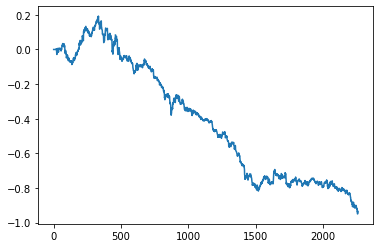

In [18]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while done == False:
    #action = agent.compute_action(state)
    #action = np.array([1,1,100,10,1000,1,1])
    action = np.random.binomial(1,np.random.uniform(0,1,7))
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(EQ_env.log_return_series).cumsum().plot()

<AxesSubplot:>

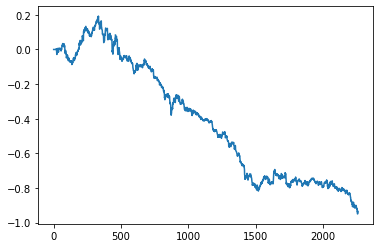

In [27]:
pd.Series(EQ_env.log_return_series).cumsum().plot()

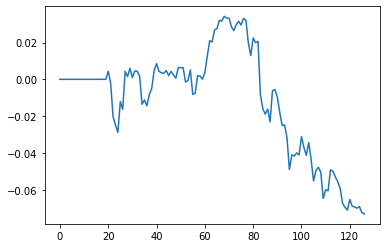

In [23]:
plt.plot(range(EQ_env.log_return_series.shape[0]),np.cumsum(EQ_env.log_return_series))

In [15]:
EQ_env.log_return_series

array([0.        , 0.        , 0.        , ..., 0.00885977, 0.00465082,
       0.00825924])

# Training a simple PPOT trainer model

In [31]:

from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

config = DEFAULT_CONFIG

In [32]:


config['model']['dim'] = 50
config['model']['conv_filters'] = [[16, [5, 1], 1], [32, [5, 1], 5], [16, [10, 1], 1]]

config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 5000
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = my_config

agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf




2020-11-17 21:55:20,816	INFO trainable.py:255 -- Trainable.setup took 21.174 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-11-17 21:55:20,820	WARNING util.py:40 -- Install gputil for GPU system monitoring.


In [36]:
np.savetxt( "/rds/general/user/asm119/home/reinforcement_learning/Aidan/Lookback_sweep/LOOKBACK_" + str(5) + ".txt", EQ_env.log_return_series)

In [33]:
for i in range(5):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
sampleagent/checkpoint_1/checkpoint-1
-0.3445635037705708


KeyboardInterrupt: 

In [ ]:
np.savetxt()

In [28]:
EQ_env.log_return_series

array([0.        , 0.        , 0.        , ..., 0.00477439, 0.00353005,
       0.00609807])

In [13]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while done == False:
    #action = agent.compute_action(state)
    #action = np.array([1,1,100,10,1000,1,1])
    action = agent.compute_action(state)
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(EQ_env.log_return_series).cumsum().plot()

NameError: name 'agent' is not defined

In [32]:
agent.export_policy_model("./PPOT_trainer")

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./PPOT_trainer/saved_model.pb


# Training a simple SAC trainer model

In [61]:

from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

config = SAC.

In [81]:
config= DEFAULT_CONFIG.copy()

In [83]:
config["num_workers"] = 1
config['env_config'] = my_config
#config["eager"] = False
trainer = SACTrainer(config=config, env=Equitydaily)

RayTaskError(AssertionError): [36mray::RolloutWorker.foreach_policy()[39m (pid=3035, ip=146.179.60.55)
  File "python/ray/_raylet.pyx", line 443, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 477, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 481, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 482, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 436, in ray._raylet.execute_task.function_executor
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 454, in __init__
    self._build_policy_map(policy_dict, policy_config)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 1059, in _build_policy_map
    policy_map[name] = cls(obs_space, act_space, merged_conf)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/policy/tf_policy_template.py", line 221, in __init__
    obs_include_prev_action_reward=obs_include_prev_action_reward)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/policy/dynamic_tf_policy.py", line 254, in __init__
    action_dist = dist_class(dist_inputs, self.model)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/models/tf/tf_action_dist.py", line 282, in __init__
    assert tfp is not None
AssertionError

In [75]:


config['model']['dim'] = 50
config['model']['conv_filters'] = [[16, [5, 1], 1], [32, [5, 1], 5], [16, [10, 1], 1]]

config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
# config["rollout_fragment_length"] = 20
# config["train_batch_size"] = 5000
# config["batch_mode"] = "complete_episodes"
# #config['num_sgd_iter'] = 20
#config['sgd_minibatch_size'] = 200
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = my_config

agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf




RayTaskError(AssertionError): [36mray::RolloutWorker.foreach_policy()[39m (pid=3037, ip=146.179.60.55)
  File "python/ray/_raylet.pyx", line 443, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 477, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 481, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 482, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 436, in ray._raylet.execute_task.function_executor
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 454, in __init__
    self._build_policy_map(policy_dict, policy_config)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 1059, in _build_policy_map
    policy_map[name] = cls(obs_space, act_space, merged_conf)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/policy/tf_policy_template.py", line 221, in __init__
    obs_include_prev_action_reward=obs_include_prev_action_reward)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/policy/dynamic_tf_policy.py", line 254, in __init__
    action_dist = dist_class(dist_inputs, self.model)
  File "/rds/general/user/asm119/home/anaconda3/envs/reinforcement/lib/python3.7/site-packages/ray/rllib/models/tf/tf_action_dist.py", line 282, in __init__
    assert tfp is not None
AssertionError

In [13]:
for i in range(100):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_60/checkpoint-60
-0.5061506751818524
sampleagent/checkpoint_65/checkpoint-65
-0.49368470121703495
sampleagent/checkpoint_71/checkpoint-71
-0.4821115109945741
sampleagent/checkpoint_76/checkpoint-76
-0.468786233771083
sampleagent/checkpoint_81/checkpoint-81
-0.457564817922941
sampleagent/checkpoint_85/checkpoint-85
-0.4472637871346042
sampleagent/checkpoint_89/checkpoint-89
-0.4369878249458647
sampleagent/checkpoint_95/checkpoint-95
-0.4253372779663288
sampleagent/checkpoint_101/checkpoint-101
-0.41454337174749484


In [15]:
for i in range(100):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_106/checkpoint-106
-0.40397033250885017
sampleagent/checkpoint_112/checkpoint-112
-0.39335519794692614
sampleagent/checkpoint_118/checkpoint-118
-0.38129948131336705
sampleagent/checkpoint_124/checkpoint-124
-0.37016420892578705
sampleagent/checkpoint_135/checkpoint-135
-0.3593468808745242
sampleagent/checkpoint_144/checkpoint-144
-0.34772263913486223
sampleagent/checkpoint_150/checkpoint-150
-0.33744415175736087
sampleagent/checkpoint_160/checkpoint-160
-0.32719978195259786
sampleagent/checkpoint_168/checkpoint-168
-0.316769920958881
sampleagent/checkpoint_176/checkpoint-176
-0.3053585011738237
sampleagent/checkpoint_182/checkpoint-182
-0.29403491345635857
sampleagent/checkpoint_188/checkpoint-188
-0.2834260929621456
sampleagent/checkpoint_196/checkpoint-196
-0.2726017154708338


<AxesSubplot:>

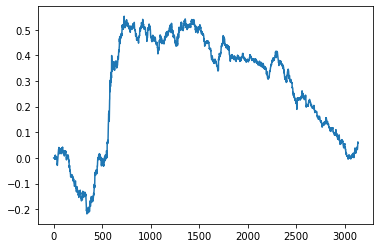

In [23]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while done == False:
    #action = agent.compute_action(state)
    #action = np.array([1,1,100,10,1000,1,1])
    action = agent.compute_action(state)
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(EQ_env.log_return_series).cumsum().plot()

In [32]:
agent.export_policy_model("./PPOT_trainer")

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./PPOT_trainer/saved_model.pb


# Overfitting Study

In [12]:

from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

config = DEFAULT_CONFIG

In [13]:


config['model']['dim'] = 50
config['model']['conv_filters'] = [[16, [5, 1], 1], [32, [5, 1], 5], [16, [10, 1], 1]]

config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 5000
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = my_config
config["shuffle_sequences"] =True

agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf




2020-11-16 21:41:51,613	INFO trainer.py:592 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-11-16 21:41:51,614	INFO trainer.py:1065 -- `_use_trajectory_view_api` only supported for PyTorch so far! Will run w/o.
2020-11-16 21:41:51,615	INFO trainer.py:619 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-11-16 21:42:10,733	INFO trainable.py:255 -- Trainable.setup took 19.122 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-11-16 21:42:10,735	WARNING util.py:40 -- Install gputil for GPU system monitoring.


In [14]:
for i in range(10):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
sampleagent/checkpoint_1/checkpoint-1
-0.5441521169529331


<AxesSubplot:>

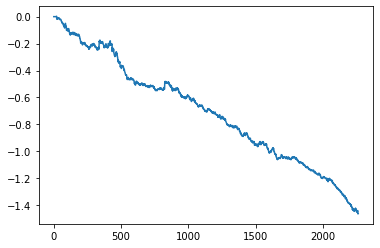

In [15]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while done == False:
    #action = agent.compute_action(state)
    #action = np.array([1,1,100,10,1000,1,1])
    action = agent.compute_action(state)
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(EQ_env.log_return_series).cumsum().plot()

In [ ]:
for i in range(500):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_21/checkpoint-21
-0.533016487670726
sampleagent/checkpoint_26/checkpoint-26
-0.5206583615687267
sampleagent/checkpoint_31/checkpoint-31
-0.5105562073572085
sampleagent/checkpoint_36/checkpoint-36
-0.4962917001748232


In [ ]:

state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while done == False:
    #action = agent.compute_action(state)
    #action = np.array([1,1,100,10,1000,1,1])
    action = agent.compute_action(state)
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(EQ_env.log_return_series).cumsum().plot()